TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, mnist_reshape_32

In [28]:
from scipy.stats import multivariate_normal

In [4]:
import math

In [5]:
import sys

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
def calc_U(shape, h, h_max): #dim_i, dim_j):
    dim_i, dim_j = calc_dim(shape, h, h_max)
    U = []
    for i in range(dim_i):
        for j in range(dim_j):
            U += [(i, j)]
    return U

In [8]:
print calc_U((32,32), 5, 6)
print len(calc_U((32,32), 5, 6))
print 16 * 16

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7

In [9]:
x = mnist.train.images[0]
image = mnist_reshape_32(x, i_offset = -10, j_offset = -10)
waveImage = WaveImage(image = image)

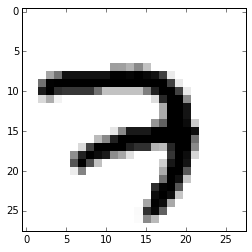

In [10]:
plt.imshow(x.reshape(28, 28), interpolation = 'nearest', cmap = 'gray_r')

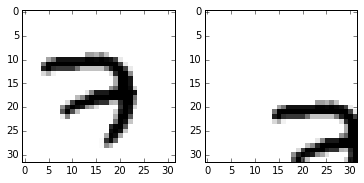

In [11]:
def mnist_reshape_32_buf(x):
    assert x.shape == (28 * 28,)
    image = x.reshape(28,28)
    image = np.append(np.zeros((2,28)), image, axis = 0)
    image = np.append(image, np.zeros((2,28)), axis = 0)
    image = np.append(np.zeros((32,2)), image, axis = 1)
    image = np.append(image, np.zeros((32,2)), axis = 1)
    return image

image = mnist_reshape_32_buf(mnist.train.images[0])

plt.subplot(1,2,1)
plt.imshow(image, interpolation = 'nearest', cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(waveImage.get_image(), interpolation = 'nearest', cmap = 'gray_r')

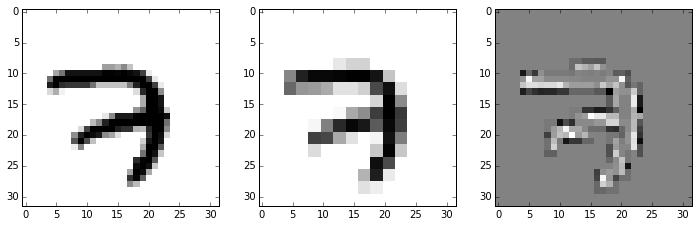

In [12]:
w_test = WaveImage(image = mnist_reshape_32(mnist.train.images[0]))
w_zero = WaveImage()
w_copy = w_test.copy()
        
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(w_test.get_image(), interpolation='nearest', cmap='gray_r')

h_max = w_test.get_h_max()
for u in w_test.get_data()[h_max - 1]:
    w_copy.set_data(h_max - 1,u,np.zeros(3))
    w_zero.set_data(h_max - 1,u,w_test.get_data()[h_max - 1][u])
    
plt.subplot(132)
plt.imshow(w_copy.get_image(), interpolation='nearest', cmap='gray_r')

    
plt.subplot(133)
plt.imshow(w_zero.get_image(), interpolation='nearest', cmap='gray')

## Creation de la base d'apprentissage

In [13]:
B_train = []
for i in range(len(mnist.train.images)):
    if i % 1000 == 0 :
        sys.stdout.write('\rstep %d' % i) 
        sys.stdout.flush()
    c = mnist.train.labels[i]
    image = mnist_reshape_32(mnist.train.images[i])
    w = WaveImage(image = image)
    data = w.get_data()
    for h in range(w.get_h_max()):
        data_h = w.get_data()[h]
        for u in data_h:
            v = data_h[u]
            B_train += [(v,(c,h,u))]                
            


step 54000

## Base de test

In [14]:
B_test = []
for i in range(len(mnist.test.images)):
    if i % 1000 == 0 :
        sys.stdout.write('\rstep %d' % i) 
        sys.stdout.flush()
    c = mnist.test.labels[i]
    image = mnist_reshape_32(mnist.test.images[i])
    w = WaveImage(image = image)
    data = w.get_data()
    for h in range(w.get_h_max()):
        data_h = w.get_data()[h]
        for u in data_h:
            v = data_h[u]
            B_test += [(v,(c,h,u))]                
            


step 9000

In [15]:
nb_pos = 1 + 1 * 1 + 2 * 2 + 4 * 4 + 8 * 8 + 16 * 16
print "# weak classifiers (# pos):", nb_pos
print "# total examples :", len(B_train)
print "# total examples / weak classifier :", len(B_train) / nb_pos

# weak classifiers (# pos): 342
# total examples : 18810000
# total examples / weak classifier : 55000


In [16]:
B_train[:100]

[(3.7832110211020362, (7, 0, (0, 0))),
 (array([-0.45183826, -0.7368873 ,  1.12561282]), (7, 1, (0, 0))),
 (array([-1.47132362,  1.47132362, -1.47132362]), (7, 2, (0, 1))),
 (array([ 1.18627458, -1.18627458, -1.18627458]), (7, 2, (1, 0))),
 (array([-1.86004914, -0.69240201,  0.69240201]), (7, 2, (0, 0))),
 (array([ 1.50710794,  3.0487747 ,  1.50710794]), (7, 2, (1, 1))),
 (array([ 0.,  0.,  0.]), (7, 3, (0, 1))),
 (array([-0.63676475,  0.19362747,  1.65539226]), (7, 3, (1, 2))),
 (array([ 1.35539224,  0.75343142,  0.5671569 ]), (7, 3, (3, 2))),
 (array([ 0.,  0.,  0.]), (7, 3, (0, 0))),
 (array([ 0.,  0.,  0.]), (7, 3, (3, 3))),
 (array([ 0.,  0.,  0.]), (7, 3, (3, 0))),
 (array([ 0.,  0.,  0.]), (7, 3, (3, 1))),
 (array([ 0.32058826, -0.23921571, -1.38529421]), (7, 3, (2, 1))),
 (array([ 0.,  0.,  0.]), (7, 3, (0, 2))),
 (array([ 0.,  0.,  0.]), (7, 3, (2, 0))),
 (array([ 0.,  0.,  0.]), (7, 3, (1, 3))),
 (array([ 0.,  0.,  0.]), (7, 3, (2, 3))),
 (array([ 1.66470599, -1.54803931,  0.

## Dictionnaire (Base d'apprentissage)

In [17]:
Data_train = [[],[],[],[],[],[],[],[],[],[]]
for c in range(10):
    Data_train[c] = [{},{},{},{},{},{}] 
    
for d in B_train:
    v = d[0]
    c = d[1][0]
    h = d[1][1]
    u = d[1][2]
    if u in Data_train[c][h]:
        Data_train[c][h][u] += [v]
    else:
        Data_train[c][h][u] = [v]


## Dictionnaire (Base de test)

In [18]:
Data_test = [[],[],[],[],[],[],[],[],[],[]]
for c in range(10):
    Data_test[c] = [{},{},{},{},{},{}] 
    
for d in B_test:
    v = d[0]
    c = d[1][0]
    h = d[1][1]
    u = d[1][2]
    if u in Data_test[c][h]:
        Data_test[c][h][u] += [v]
    else:
        Data_test[c][h][u] = [v]


In [19]:
print len(Data_train[0][0][(0,0)])
print len(Data_train[1][0][(0,0)])
print len(Data_train[2][0][(0,0)])
print len(Data_train[3][0][(0,0)])

5444
6179
5470
5638


In [20]:
print np.mean(Data_train[0][0][(0,0)],0)
print np.mean(Data_train[0][1][(0,0)],0)
print np.mean(Data_train[0][2][(0,0)],0)
print np.mean(Data_train[0][2][(0,1)],0)
print np.mean(Data_train[0][5][(15,15)],0)


4.24175191197
[-0.17378325 -0.18218565 -0.61126905]
[-1.4632876  -1.58955317  1.41608588]
[-1.81462207  1.75352377 -1.15939339]
[ 0.  0.  0.]


In [21]:
print Data_train[0][5][(7,7)]

[array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.72745101,  0.24509807,  0.0019608 ]), array([ 0.,  0.,  0.]), array([ 0.00588235,  0.00588235,  0.00588235]), array([ 0.,  0.,  0.]), array([ 0.20000002,  0.34901962, -0.19607845]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.03529412,  0.03529412,  0.03529412]), array([ 0.,  0.,  0.]), array([ 0.06666667,  0.06666667,  0.06666667]), array([ 0.,  0.,  0.]), array([ 0.69803923,  0.05098039,  0.00784313]), array([ 0.50588237,  0.34901964, -0.34901964]), array([ 0.06078432, -0.06078432, -0.06078432]), array([ 0.25686276,  0.25686276,  0.25686276]), array([-0.3039216 , -0.51176475,  0.24901963]), array([ 0.78039219,  0.18823532,  0.03921571]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.09607843, -0.09607843,  0.09607843]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.08235

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


'for angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.pause(.001)'

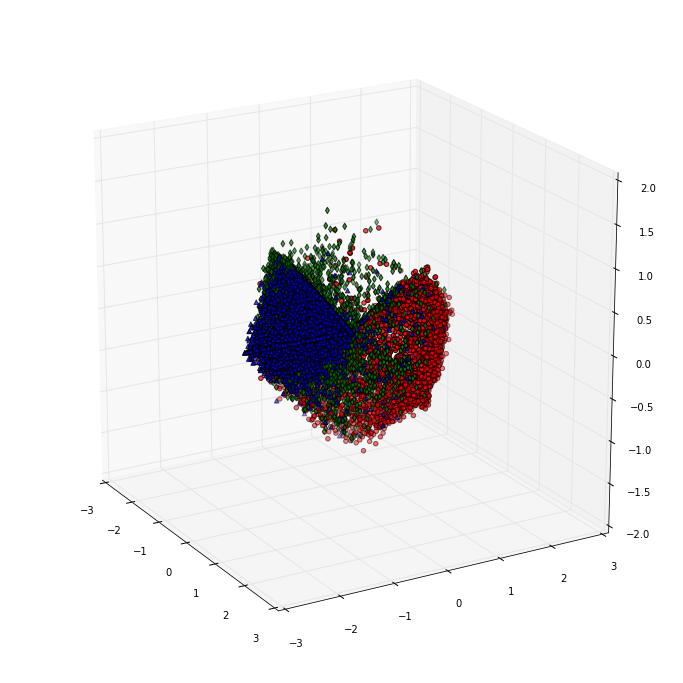

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

h = 4 #4
i = 3 #5
j = 3 #5

test = np.array(Data_train[0][h][(i,j)])
ax.scatter(test[:,0], test[:,1], test[:,2],c='r', marker = 'o')

test2 = np.array(Data_train[1][h][(i,j)])
ax.scatter(test2[:,0], test2[:,1], test2[:,2],c='b', marker = '^')

test3 = np.array(Data_train[3][h][(i,j)])
ax.scatter(test3[:,0], test3[:,1], test3[:,2],c='g', marker = 'd')

ax.view_init(20, -30)

'''for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)'''

# Probas elementaires 

In [23]:
mu = []
Sigma = []
rho = []
for c in range(10):
    mu += [{}]
    Sigma += [{}]
    rho += [{}]
    for h in range(0,6):
        mu[c][h] = {}
        Sigma[c][h] = {}
        rho[c][h] = {}
        for u in calc_U((32, 32), h, 6):
            if u in Data_train[c][h]:
                data = []
                cpt = 0
                for v in Data_train[c][h][u]:
                    if np.linalg.norm(v) < 1e-16:
                        cpt += 1
                    else:
                        data += [v]
                #if h == -1 :
                #    print len(data)
                if len(data) > 1:
                    mu[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                    Sigma[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                    rho[c][h][u] = float(cpt) / len(Data_train[c][h][u])
                else:
                    mu[c][h][u] = np.zeros(3)
                    Sigma[c][h][u] = np.zeros((3,3))
                    rho[c][h][u] = 1.
            

### Reconstruction


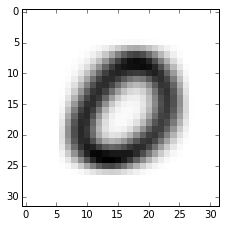

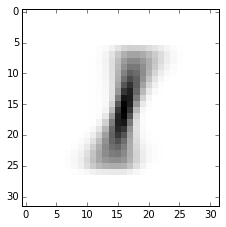

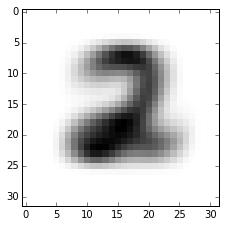

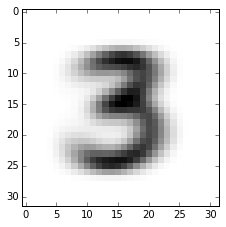

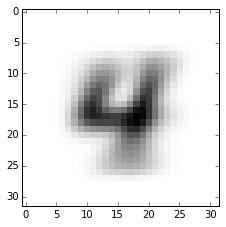

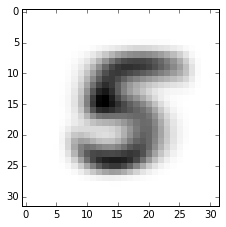

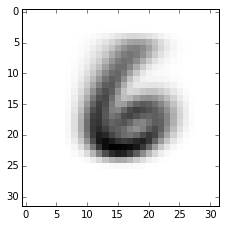

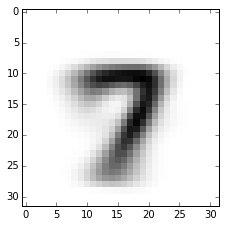

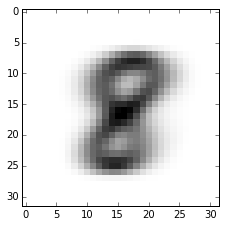

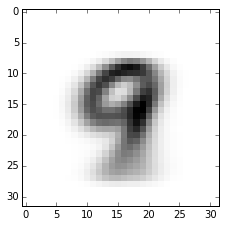

In [104]:
avg_image = {}
for c in range(10):
    w = WaveImage()
    for h in range(6):
        for u in calc_U((32, 32), h, 6):
            w.set_data( h, u, mu[c][h][u] * (1 - rho[c][h][u]))
    avg_image[c] = w.get_image()
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(w.get_image(), interpolation='nearest', cmap='gray_r')



### Test distribution

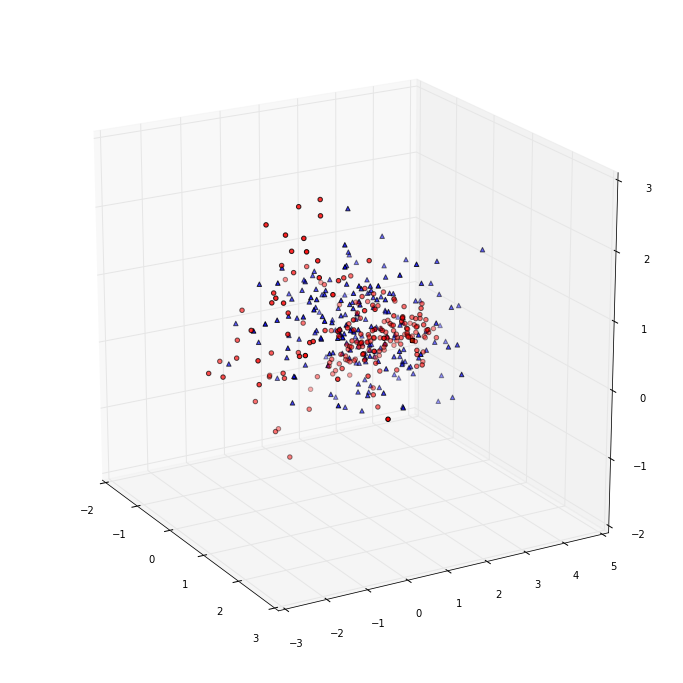

In [25]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

c = 8
h = 3
u = (2,2)

n = 200

test2 = np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u] , n)
#test2 = np.random.multivariate_normal(mu[(c,h,u)], Sig_test * 0 , n)
#test2 = np.random.multivariate_normal(-mu[(c,h,u)], np.eye(3,3), n)
ax.scatter(test2[:,0], test2[:,1], test2[:,2],c='b', marker = '^')

#test3 = np.random.multivariate_normal(-mu[(c,h,u)], np.eye(3,3), n)
#ax.scatter(test3[:,0], test3[:,1], test3[:,2],c='g', marker = 'd')

index = np.arange(len(Data_train[c][h][u]))
np.random.shuffle(index)
test = np.array(Data_train[c][h][u])
ax.scatter(test[index[:n],0], test[index[:n],1], test[index[:n],2],c='r', marker = 'o')

v = Data_test[c][h][u][0]
ax.scatter(v[0], v[1], v[2],c='g', marker = 's')

ax.view_init(20, -30)

## Baseline recognition rate

In [26]:
NB_CLASSES = 10
NB_TRIALS = 100

In [29]:

c_ref = 9
#h = 0
#u = (0,0)
mem_c_out = []
mem_classif = []
for c_ref in range(NB_CLASSES):
    for i in range(NB_TRIALS):
        pi = np.ones(10) / 10
        log_score = np.zeros(10)
        mem_pi = [pi]
        for h in range(6):
            #print '*************************'
            #print '*********' , 'h = ' , h , '************'
            #print '*************************'
            for u in calc_U((32, 32), h, 6):
                #print U[h]
                #u = (u_ref[1],u_ref[2])
                lik = np.zeros(10)
                for c in range(10):
                    v = Data_test[c_ref][h][u][i]
                    if np.linalg.norm(v) < 1e-16:
                        lik[c] = rho[c][h][u]
                    else:
                        if np.linalg.norm(mu[c][h][u]) > 1e-16:
                            dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                            #print 'mean =', mu[c][h][u]
                            #print 'cov =', Sigma[c][h][u]
                            lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                        else:
                            lik[c] = 0
                    lik[c] = max(lik[c],1e-16)
                #print 'lik =' + str(lik) 
                log_score += np.log(lik) 
                max_log_score = max(log_score)
                #print 'log_score', log_score
                #print 'max(log_score) :', max_log_score
                log_score -= max_log_score
                Z = np.sum(np.exp(log_score))
                pi = np.exp(log_score)/Z
                mem_pi += [pi]
                #for c in range(10):
                #    pi[c] = lik[c]/lik.sum()
                #print 'pi =' + str(pi)
                #print 'max(pi) = ',max(pi)
                sum_H = - pi * np.log(lik)
                #print np.log(lik)
                #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
                #print '**** H = ',sum_H.sum()
        c_out =  np.where(pi == max(pi))[0][0]
        mem_c_out += [c_out]
        #print i, c_out
        sys.stdout.write('\rclasse %d, step %d, \t  rep : %d' % (c_ref, i, c_out)) 
        sys.stdout.flush()
        mem_classif += [c_out == c_ref]
    

step 99, 	 classe : 9, rep : 9

In [30]:
np.where(np.array(mem_classif)==True,1,0).sum()/ (NB_CLASSES * NB_TRIALS / 100.0)

88.900000000000006

#### Liste des coordonnées par niveau : U[h], h $\in$ 0..5

In [34]:
axes = []
h_max = 6
shape = (32,32)

'''for h in range(h_max):
    h_opp = 5 - h
    b_moins = -.5
    b_plus = 27.5
    intervalle = b_plus - b_moins
    coord_max = int(26.5 / 2**h_opp) + 1
    unite = max(intervalle / coord_max, 2**h_opp)
    print unite
    coords = []
    for j in range(coord_max):
        coords += [b_moins + (j+.5) * unite]
    axes += [coords]
print axes
print '''''

U = {}
for h in range(h_max):
    #U_ref = {}
    #for pos_i in axes[h]:
    #    for pos_j in axes[h]:
    #        U_ref[h] += [(pos_i, pos_j)]
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    
    print 'Niveau ', h, ' : '
    print ' U[' , h, '] :', U[h]
    #print ' U_ref[h] :', U_ref[h]
    print ''
    


Niveau  0  : 
 U[ 0 ] : {(0, 0): 1}

Niveau  1  : 
 U[ 1 ] : {(0, 0): 1}

Niveau  2  : 
 U[ 2 ] : {(0, 1): 1, (1, 0): 1, (0, 0): 1, (1, 1): 1}

Niveau  3  : 
 U[ 3 ] : {(0, 1): 1, (1, 2): 1, (3, 2): 1, (0, 0): 1, (3, 3): 1, (3, 0): 1, (3, 1): 1, (2, 1): 1, (0, 2): 1, (2, 0): 1, (1, 3): 1, (2, 3): 1, (2, 2): 1, (1, 0): 1, (0, 3): 1, (1, 1): 1}

Niveau  4  : 
 U[ 4 ] : {(7, 3): 1, (4, 7): 1, (1, 3): 1, (6, 4): 1, (3, 0): 1, (5, 4): 1, (0, 7): 1, (5, 6): 1, (2, 6): 1, (1, 6): 1, (5, 1): 1, (3, 7): 1, (2, 5): 1, (0, 3): 1, (7, 2): 1, (4, 0): 1, (1, 2): 1, (6, 7): 1, (3, 3): 1, (2, 0): 1, (7, 6): 1, (4, 4): 1, (6, 3): 1, (1, 5): 1, (3, 6): 1, (2, 2): 1, (7, 7): 1, (5, 7): 1, (5, 3): 1, (4, 1): 1, (1, 1): 1, (2, 7): 1, (3, 2): 1, (0, 0): 1, (6, 6): 1, (5, 0): 1, (7, 1): 1, (4, 5): 1, (0, 4): 1, (5, 5): 1, (1, 4): 1, (6, 0): 1, (7, 5): 1, (2, 3): 1, (2, 1): 1, (4, 2): 1, (1, 0): 1, (6, 5): 1, (3, 5): 1, (0, 1): 1, (7, 0): 1, (4, 6): 1, (5, 2): 1, (6, 1): 1, (3, 1): 1, (0, 2): 1, (7, 4): 1, (0

#### Construction d'un arbre de coordonnées multi-niveau (descendants pour (i,j) au niveau h)

In [35]:
def fils_rec(shape, h, h_max, i, j):
    
    if h < h_max :
        dim_i, dim_j = calc_dim(shape, h, h_max)
        if i < dim_i and j < dim_j :
            rep = [(h,(i,j)), [], [], [], []]
            rep[1] = fils_rec(shape, h + 1, h_max, i * 2, j * 2)
            rep[2] = fils_rec(shape, h + 1, h_max, i * 2, j * 2 + 1)
            rep[3] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2)
            rep[4] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2 + 1)
        else:
            rep = []
    else:
        rep = []
    return rep
    


In [36]:
U_tree = fils_rec(shape, 0, h_max, 0, 0) 
print U_tree

[(0, (0, 0)), [(1, (0, 0)), [(2, (0, 0)), [(3, (0, 0)), [(4, (0, 0)), [(5, (0, 0)), [], [], [], []], [(5, (0, 1)), [], [], [], []], [(5, (1, 0)), [], [], [], []], [(5, (1, 1)), [], [], [], []]], [(4, (0, 1)), [(5, (0, 2)), [], [], [], []], [(5, (0, 3)), [], [], [], []], [(5, (1, 2)), [], [], [], []], [(5, (1, 3)), [], [], [], []]], [(4, (1, 0)), [(5, (2, 0)), [], [], [], []], [(5, (2, 1)), [], [], [], []], [(5, (3, 0)), [], [], [], []], [(5, (3, 1)), [], [], [], []]], [(4, (1, 1)), [(5, (2, 2)), [], [], [], []], [(5, (2, 3)), [], [], [], []], [(5, (3, 2)), [], [], [], []], [(5, (3, 3)), [], [], [], []]]], [(3, (0, 1)), [(4, (0, 2)), [(5, (0, 4)), [], [], [], []], [(5, (0, 5)), [], [], [], []], [(5, (1, 4)), [], [], [], []], [(5, (1, 5)), [], [], [], []]], [(4, (0, 3)), [(5, (0, 6)), [], [], [], []], [(5, (0, 7)), [], [], [], []], [(5, (1, 6)), [], [], [], []], [(5, (1, 7)), [], [], [], []]], [(4, (1, 2)), [(5, (2, 4)), [], [], [], []], [(5, (2, 5)), [], [], [], []], [(5, (3, 4)), [], [

#### Calcul des descendants et des parents

In [40]:
def calcule_desc(U_tree, mem_h_u_todo):
    if U_tree == []:
        return []
    else :
        if U_tree[0] in mem_h_u_todo :
            rep = [U_tree[0]]
        else:
            rep = []
        if U_tree[1] != [] :
            rep += calcule_desc(U_tree[1], mem_h_u_todo)
        if U_tree[2] != [] :
            rep += calcule_desc(U_tree[2], mem_h_u_todo)
        if U_tree[3] != [] :
            rep += calcule_desc(U_tree[3], mem_h_u_todo)
        if U_tree[4] != [] :
            rep += calcule_desc(U_tree[4], mem_h_u_todo)    
        return rep

In [46]:
print calcule_desc(U_tree, [(5, (5, 7)), (4, (2, 3))])

[(4, (2, 3)), (5, (5, 7))]


In [57]:
def find_desc (U_tree, (h, u)):
    if U_tree == []:
        return None
    else :    
        if U_tree[0] == (h, u) :
            return U_tree
        else:
            desc_1 = find_desc(U_tree[1], (h, u))
            if desc_1 != None:
                return desc_1
            desc_2 = find_desc(U_tree[2], (h, u))
            if desc_2 != None:
                return desc_2
            desc_3 = find_desc(U_tree[3], (h, u))
            if desc_3 != None:
                return desc_3
            desc_4 = find_desc(U_tree[4], (h, u))
            if desc_4 != None:
                return desc_4

In [58]:
print find_desc(U_tree, (4, (2, 3)))

[(4, (2, 3)), [(5, (4, 6)), [], [], [], []], [(5, (4, 7)), [], [], [], []], [(5, (5, 6)), [], [], [], []], [(5, (5, 7)), [], [], [], []]]


In [129]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [60]:
print calcule_asc_path(5,(15,3))

[(5, (15, 3)), (4, (7, 1)), (3, (3, 0)), (2, (1, 0)), (1, (0, 0)), (0, (0, 0))]


#### Prediction

In [61]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [62]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [63]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

#### Métriques

In [64]:
# Entropy (over counterfactual viewpoint (h_plus, u_plus))

def calc_H_plus(log_score, v_plus, h_plus, u_plus):
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_H = - pi_plus * np.log(pi_plus)
    #print 'sum_H : ', sum_H
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_H.sum()


In [65]:
# Free Energy (over counterfactual viewpoint (h_plus, u_plus))

def calc_F_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_F = - pi_plus * (np.log(lik_plus) - np.log(pi_plus) + np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_F.sum()   


In [66]:
def calc_IB_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_IB = pi_plus * (np.log(pi_plus) - np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_IB.sum()   


In [67]:
# Gibbs Energy

def calc_E_plus(pi, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    sum_E = pi * lik_plus
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_E.sum()   

#### Generators

In [68]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
    else:
        return np.zeros(3)

In [69]:
def monte_carlo_generator(c, h, u):
    if np.random.random() > rho[c][h][u]:
        return np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u], 1)[0]
    else:
        return np.zeros(3)

#### Utilitaires

In [94]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [114]:
def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 31.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

#### Likelihood map : `lik_predictive[c][h][u]`

In [70]:
h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            log_score = np.zeros(10)
            v_predictive = argmax_generator(c, h, u)
            lik = calc_lik(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

#### Basic saliency map : `pi_predictive[c][u]` (h = 5)

In [71]:
pi_predictive = {}
h = h_max - 1
for c in range(10):
    pi_predictive[c] = {}
    for i in range(16):
        for j in range(16):
            u = (i, j)
            liste_path = calcule_asc_path(h, u)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                v_predictive = argmax_generator(c, h_path, u_path)
                lik_path = calc_lik(v_predictive, h_path, u_path)
                log_score_path = update_log_score(log_score_path, lik_path)
            pi_path = calc_pi(log_score_path)
            pi_predictive[c][u] = pi_path[c]   


In [81]:
liste_path

[(5, (15, 15)),
 (4, (7, 7)),
 (3, (3, 3)),
 (2, (1, 1)),
 (1, (0, 0)),
 (0, (0, 0))]

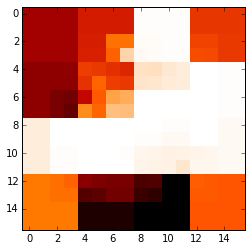

In [96]:
c = 0
sal_map = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        sal_map[i,j] = pi_predictive[c][(i,j)] 
        
plt.imshow(sal_map, interpolation = 'nearest', cmap = 'gist_heat')

#### Effective saliency map : `pi_predictive[c][u]` (h = 5) 

In [83]:
h = h_max - 1
pi_predictive_eff = {}
for c in range(10):
    print c
    pi_predictive_eff[c] = {}
    
    mem_h_u = []
    mem_h_u_todo = {}
    for u_add in U[h]:
        mem_h_u_todo[(5, u_add)] = 1
    
    while len(mem_h_u_todo) > 0 :    
        pi_predictive_plus = {}
        for (h, u) in mem_h_u_todo:
            liste_path = calcule_asc_path(h, u)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    log_score_path = update_log_score(log_score_path, lik_predictive[c][h_path][u_path])
            pi_path = calc_pi(log_score_path)
            #print pi_path
            pi_predictive_plus[u] = pi_path[c] 
            #print h_plus, u_plus
        keys = pi_predictive_plus.keys()
        values = np.array(pi_predictive_plus.values())
        k = np.argmax(values)
        u_tilde = keys[k]
        #print len(pi_predictive_plus), len(mem_h_u), (values[k], (h, u))
        
        pi_predictive_eff[c][u_tilde] = values[k]
        mem_h_u_todo.pop((h, u_tilde)) 
        liste_path = calcule_asc_path(h, u_tilde)
        log_score_path = np.zeros(10)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                mem_h_u += [(h_path, u_path)]       
        
        #print 'CHOIX :', (h, u)
        
        
        

0
1
2
3
4
5
6
7
8
9


In [102]:
print pi_predictive_eff[5]

{(7, 3): 0.10401749049766289, (6, 9): 0.12240595441490019, (12, 1): 0.10001064037236918, (11, 11): 0.093513112384249364, (7, 12): 0.11717824436983197, (14, 4): 0.10082044025744236, (13, 4): 0.095960567004934563, (12, 12): 0.099795343591023294, (0, 7): 0.10000000000000001, (15, 1): 0.10000000000000001, (1, 6): 0.10013115120499996, (0, 10): 0.10000000000000001, (3, 7): 0.10549496730816664, (2, 5): 0.10567039153087246, (1, 11): 0.10003508707133756, (8, 5): 0.56687620582945475, (5, 8): 0.12300781104785243, (4, 0): 0.10000000000000001, (10, 8): 0.075128207099404695, (9, 0): 0.10000000000000001, (6, 7): 0.11906788563579215, (5, 5): 0.12356155768418429, (11, 5): 0.19754138976098357, (10, 7): 0.15327333479873168, (7, 6): 0.12636792595883831, (6, 10): 0.32551755631131724, (12, 6): 0.13386899974362337, (15, 11): 0.10000000000000001, (14, 1): 0.10000000000000001, (13, 7): 0.089909875737562275, (0, 4): 0.10000000000000001, (15, 4): 0.10000000000000001, (1, 1): 0.10000000000000001, (8, 15): 0.10000

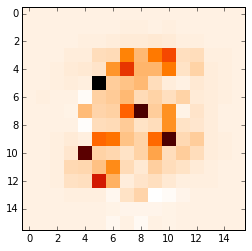

In [99]:
c = 9
sal_map = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        sal_map[i,j] = pi_predictive_eff[c][(i,j)] 
        
plt.imshow(sal_map, interpolation = 'nearest', cmap = 'gist_heat_r')

In [118]:
def affiche_path(pi_predictive): 
    pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive)
    for c in range(10):
        image_moy = avg_image[c] #np.mean(np.array(data_visu[c]),0)
        plt.figure(figsize=(12,8))
        plt.subplot(131)
        plt.imshow(image_moy, interpolation='nearest', cmap='gray_r')
        plt.title(c)
        path_i = []
        path_j = []
        image_pi = np.zeros((14,14))
        for cpt in range(6):
            (pi_pred, u) = pi_predictive_sorted[c][-1-cpt]
            #(pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
            #print c,pi_pred
            path_i += [u[0] * 2 + 1.5]
            path_j += [u[1] * 2 + 1.5]
        affiche_path_mnist(path_i, path_j)
        plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)

        plt.subplot(132)
        sal_map = np.zeros((16, 16))
        for i in range(16):
            for j in range(16):
                sal_map[i,j] = pi_predictive[c][(i,j)] 



        plt.imshow(sal_map, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)

    


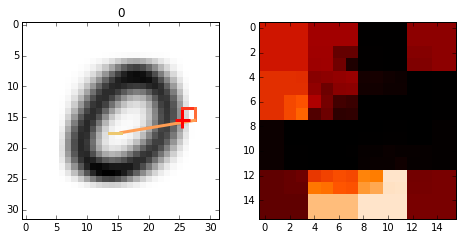

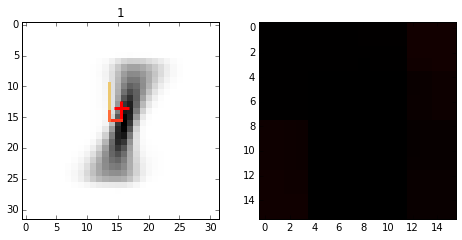

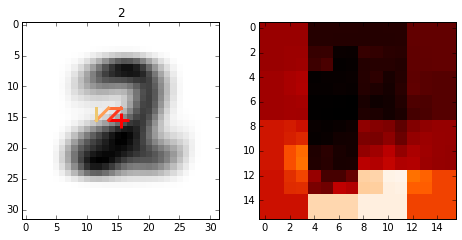

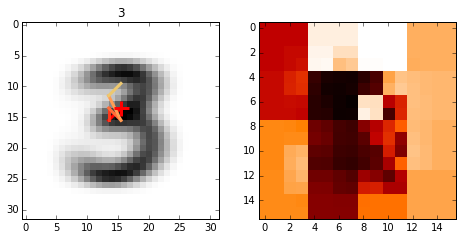

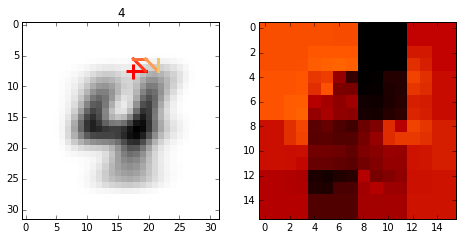

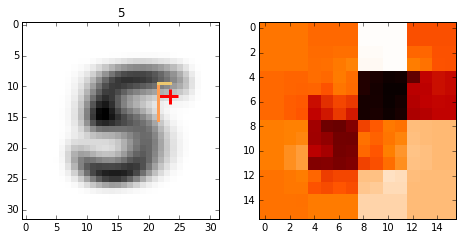

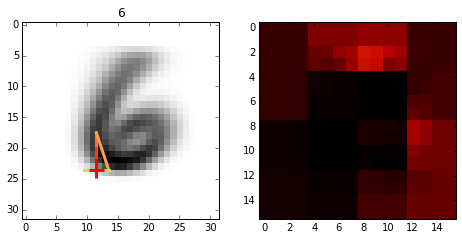

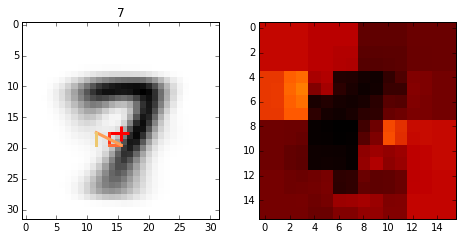

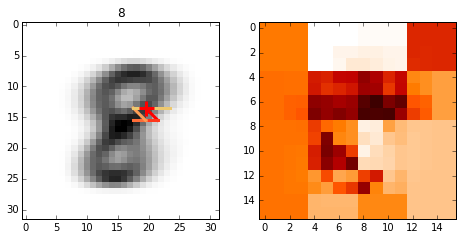

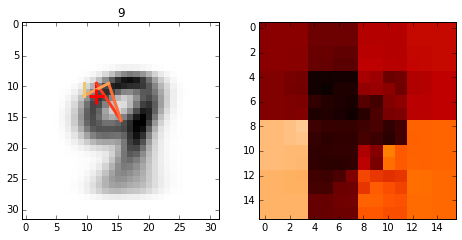

In [119]:
affiche_path(pi_predictive)

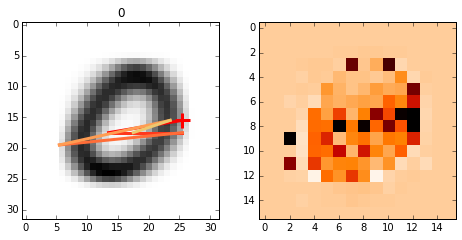

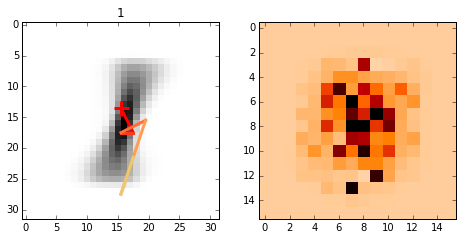

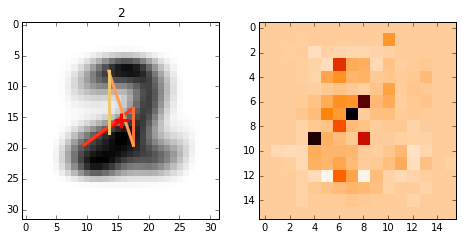

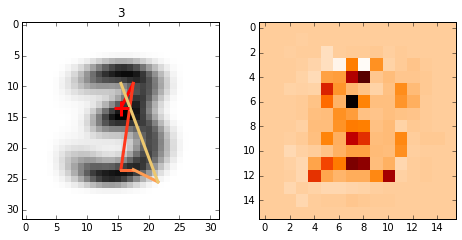

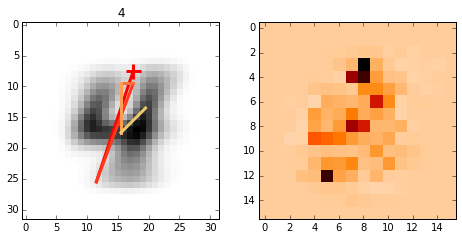

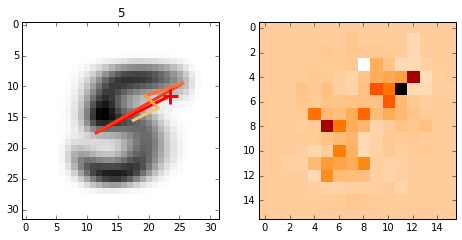

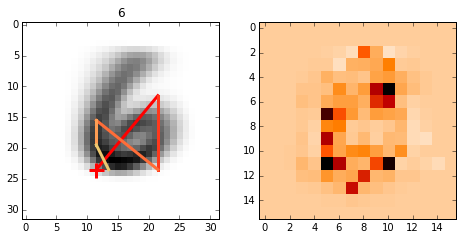

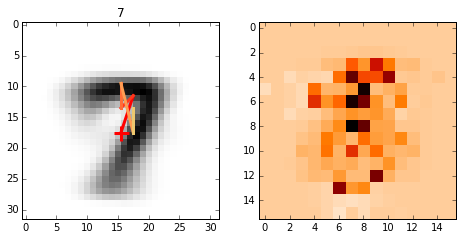

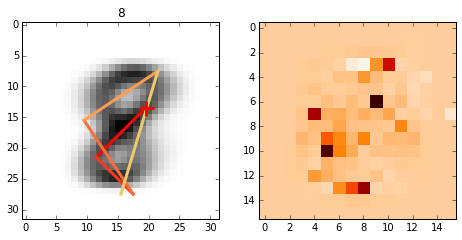

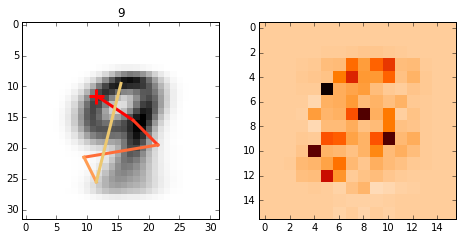

In [120]:
affiche_path(pi_predictive_eff)

#### !!!TODO!!! Posterior predictif : $q(.)|_{\tilde{z}, \text{u}}$ basé sur une liste de vues `liste_u`  

In [ ]:
# Monte-Carlo generative model

def calc_pi_MC_plus(pi, liste_u, nb_sample):
    nb_pos = len(liste_u)
    pi_MC_plus = np.zeros(nb_pos)
    # !!! Prediction de z selon le prior (a mettre en argument) !!!
    tirage = np.random.multinomial(1,pi)
    c_MC = np.where(tirage==1)[0][0]
    # Accumulation sur liste_u
    for k in range(len(liste_u)) : 
        # choix de u = (h_plus, u_plus)
        (h_plus, u_plus) = liste_u[k]
        for nb_obs in range(nb_sample):      
            v_MC = monte_carlo_generator(c_MC, h_plus, u_plus)
            lik_plus = calc_lik(v_MC, h_plus, u_plus)
            log_score_plus = update_log_score(np.zeros(10), lik_plus)
            pi_plus = calc_pi(log_score_plus)
            pi_MC_plus[k] += pi_plus[c_MC] / nb_sample
    return pi_MC_plus


In [50]:
# Argmax generative model

def calc_pi_predictive_plus(pi,liste_u):
    nb_pos = len(liste_u)
    pi_predictive_plus = np.zeros(nb_pos)
    # !!! Prediction de z selon le prior (a mettre en argument) !!!
    c_predictive = np.argmax(pi)
    for k in range(len(liste_u)) : 
        (h_plus, u_plus) = liste_u[k]
        '''if rho[c_predictive][h_plus][u_plus] < .5 :
            v_predictive = mu[c_predictive][h_plus][u_plus]
        else:
            v_predictive = np.zeros(3)
        lik_plus = calc_lik(v_predictive, h_plus, u_plus)'''
        # Lecture de la likelihood map
        lik_plus = lik_predictive[c_predictive][h_plus][u_plus]
        log_score_plus = update_log_score(np.zeros(10), lik_plus)
        pi_plus = calc_pi(log_score_plus)
        pi_predictive_plus[k] = pi_plus[c_predictive] 
    return pi_predictive_plus

In [126]:
def prediction_based_policy(log_score, actions_set, mem_h_u):
    # actions_set ne contient que les positions de niveau 5
    h = h_max - 1
    ## 1 ##
    z_tilde = np.argmax(log_score)
    pi_predictive_plus = {}
    ## 2 ## Utilisation de lik_predictive
    for u in actions_set:
        liste_path = calcule_asc_path(h, u)
        log_score_path = np.zeros(10)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                log_score_path = update_log_score(log_score_path, lik_predictive[z_tilde][h_path][u_path])
        pi_path = calc_pi(log_score_path)
        pi_predictive_plus[u] = pi_path[z_tilde] 
    ## 3 ##
    keys = pi_predictive_plus.keys()
    values = np.array(pi_predictive_plus.values())
    k = np.argmax(values)
    u_tilde = keys[k]
    return u_tilde

In [155]:
def scene_exploration(z_ref, ind_test, log_score, actions_set, mem_h_u):
    
    TOUR = 0
    END = False
    h = h_max - 1
    
    while END == False:
        print '************************************'
        print '******       TOUR    ' + str(TOUR + 1) + '        ******'
        print '************************************'
        # 1. CHOIX
        u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u)
        
        print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        liste_path = calcule_asc_path(h, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[z_ref][h_path][u_path][ind_test] 
                lik_path = calc_lik(v, h_path, u_path)
                log_score = update_log_score(log_score, lik_path)
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                print 'pi : ', pi
                #mem_pi += [pi]
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                print 'out :', out
                print 'pi[out] : ', pi[out]
                print 'H : ', H
                #mem_H += [H]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
                
        print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
        #mem_u_final += [u]
        #mem_pi_copy += [list(mem_pi)]
        #mem_H_copy += [list(mem_H)]
        #mem_out += [out]
        #if TOUR == 50 or (TOUR >5 and pi[out] > .99999):   
        if TOUR == len(U[h_max - 1]) - 1 or pi[out] > .9999:
            END = True
            print '************************************'
            print '******         FINI          *******'
            print '************************************' 
            return out
            #mem_out_final += [out]
            #mem_turn += [TOUR]
        else:
            TOUR += 1
           
        

In [159]:
z_ref = 8
ind_test = 3

# initial
log_score = np.zeros(10)
pi = np.ones(10) / 10

# global coef --> log_score initial
h, u = 0, (0, 0)
mem_h_u = [(h, u)]
v = Data_test[z_ref][h][u][ind_test]
lik = calc_lik(v,h,u)
log_score = update_log_score(log_score, lik)
pi = calc_pi(log_score)

# initial actions set
actions_set = {}
for i in range(16):
    for j in range(16):
        actions_set[(i, j)] = 1
        
z_pred = scene_exploration(z_ref, ind_test, log_score, actions_set, mem_h_u)

************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 12)
pi :  [  5.28891845e-01   2.07146971e-07   2.58404880e-02   3.22449283e-02
   2.15746690e-02   1.43856554e-01   2.30599649e-02   5.32434017e-03
   2.00000890e-01   1.92061134e-02]
out : 0
pi[out] :  0.528891845465
H :  1.4164008205
pi :  [  2.18946621e-01   4.55533069e-09   1.31493506e-02   9.57240063e-02
   2.93402428e-03   1.01655378e-02   4.86367720e-05   1.56999241e-01
   1.81973321e-01   3.20059257e-01]
out : 9
pi[out] :  0.320059257242
H :  1.64373147077
pi :  [  8.13160169e-02   6.96524257e-09   1.68301943e-02   1.31256722e-01
   2.87028787e-03   5.07989075e-03   5.02098143e-05   1.87967723e-01
   1.46457911e-01   4.28171037e-01]
out : 9
pi[out] :  0.428171036585
H :  1.54218392506
pi :  [  2.54285480e-02   9.03634924e-09   1.82868368e-02   1.54767217e-01
   2.80316075e-03   5.36314121e-03   4.36989496e-05   1.92992116e-01
   1.23377784e-01   4.76937489e

## TODO...

## Modèle prédictif exact

In [ ]:
h_max = 6
c_ref = 2
print '*****', c_ref, '*****'
#h = 0
#u = (0,0)
mem_out_final = []
mem_turn = []

for i in range(100):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
    
    # Initialisation
    
    (h, u) = (0, (0, 0))
    mem_h_u_todo = {(0, (0, 0)):1}
    for u_add in U[h_max - 1]:
        mem_h_u_todo[(h_max - 1, u_add)] = 1

    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []

    # Premiere estimation pi (0,(0,0))
    mem_h_u += [(h,u)]
    mem_h_u_todo.pop((h,u))
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    print 'H : ', H
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
    out = np.argmax(pi)

    while END == False:
        
        # CHOIX
        pi_predictive_plus = {}
        c_predictive = np.argmax(pi)
        for (h_plus, u_plus) in mem_h_u_todo:
            liste_path = calcule_asc_path(h_plus, u_plus)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    '''#test_pred = np.random.random() > rho[c_predictive][h_path][u_path]
                    test_pred = rho[c_predictive][h_path][u_path] < .5       
                    if test_pred:
                        v_predictive = mu[c_predictive][h_path][u_path]
                        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
                    else:
                        v_predictive = np.zeros(3)
                    lik_path = calc_lik(v_predictive, h_path, u_path)
                    log_score_path = update_log_score(log_score_path, lik_path)'''
                    log_score_path = update_log_score(log_score_path, lik_predictive[c_predictive][h_path][u_path])
            pi_path = calc_pi(log_score_path)
            pi_predictive_plus[(h_plus, u_plus)] = pi_path[c_predictive] 
            #print h_plus, u_plus
        
        keys = pi_predictive_plus.keys()
        values = np.array(pi_predictive_plus.values())
        k_next = np.argmax(values) #np.argmin(values) #
        (h, u) = keys[k_next]
        
        print 'CHOIX :', (h, u)
        
        # LECTURE
        mem_h_u_todo.pop((h,u))
        liste_path = calcule_asc_path(h, u)
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[c_ref][h_path][u_path][i] 
                lik_path = calc_lik(v, h_path, u_path)
                log_score = update_log_score(log_score, lik_path)
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                print 'pi : ', pi
                mem_pi += [pi]
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                print 'pi[out] : ', pi[out]
                print 'H : ', H
                mem_H += [H]
                
        print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
        mem_u_final += [u]
        mem_pi_copy += [list(mem_pi)]
        mem_H_copy += [list(mem_H)]
        mem_out += [out]
        #if TOUR == 50 or (TOUR >5 and pi[out] > .99999):   
        if TOUR == len(U[h_max - 1]) - 1 or pi[out] > .9999:
            END = True
            print '************************************'
            print '******         FINI          *******'
            print '************************************'   
            mem_out_final += [out]
            mem_turn += [TOUR]
        else:
            TOUR += 1
            print '************************************'
            print '******       TOUR    ' + str(TOUR) + '        ******'
            print '************************************'
        

In [ ]:
h_max = 6

c_ref = 8
print '*****', c_ref, '*****'
#h = 0
#u = (0,0)

mem_out_final = []
mem_turn = []


for i in range(10):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
   
    (h, u) = (0, (0, 0))
    mem_U_tree = U_tree_ref = U_tree
    mem_h_u_todo = {(0, (0, 0)) : 1}
    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []
    while END == False:
        print h, u
        if (h,u) not in mem_h_u:
            mem_h_u += [(h,u)]
            mem_h_u_todo.pop((h,u))
            v = Data_test[c_ref][h][u][i]     
            lik = calc_lik(v,h,u)
            print 'lik : ', lik
            log_score = update_log_score(log_score, lik)
            print 'log_score : ', log_score
            pi = calc_pi(log_score)
            print 'pi : ', pi
            mem_pi += [pi]
            H = np.sum(- pi * np.log(pi))
            print 'H : ', H
            mem_H += [H]
            out = np.argmax(pi)
            print 'pi[out] =', pi[out]
            print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
            VU = False
            if h == h_max - 1 and pi[out] > .999999 :
                SEUIL = True
        else :
            print h, u, 'déjà vu'
            #VU = True
            print ''
        if h < h_max - 1:
            if U_tree_ref[1] != [] :
                if U_tree_ref[1][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[1][0]] = 1
            if U_tree_ref[2] != [] :
                if U_tree_ref[2][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[2][0]] = 1
            if U_tree_ref[3] != [] :
                if U_tree_ref[3][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[3][0]] = 1
            if U_tree_ref[4] != [] :
                if U_tree_ref[4][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[4][0]] = 1
            liste_u_desc = calcule_desc(U_tree_ref, mem_h_u_todo)
            '''for i_fils in range(1,5):
                if U_tree_ref[i_fils] != [] and U_tree_ref[i_fils] not in liste_u and U_tree_ref[i_fils][0] not in mem_h_u:
                    liste_u+= [U_tree_ref[i_fils]] 
            print 'TOUR = ',TOUR, 'h = ', h, 'len(liste_u) =', len(liste_u)'''
            print 'liste_u_desc :', liste_u_desc
            for pos_test in mem_h_u:
                if pos_test in liste_u_desc:
                    liste_u_desc.remove(pos_test)
            if len(liste_u_desc) == 0 :
                print 'HUM!!', 'h = ', h, 'u = ', u
                c_in = raw_input()
                h = 0
                u = (0,0)
                mem_U_tree = U_tree_ref = U_tree
            else:
                #c = raw_input()
                '''H_plus = np.zeros(len(liste_u_desc))
                F_plus = np.zeros(len(liste_u_desc))
                E_plus = np.zeros(len(liste_u_desc))
                IB_plus = np.zeros(len(liste_u_desc))
                for k in []: #range(len(liste_u_desc)):
                    (h_plus, u_plus) = liste_u_desc[k] 
                    v_plus = Data_test[c_ref][h_plus][u_plus][i]
                    H_plus[k] = calc_H_plus(log_score, v_plus, h_plus, u_plus)
                    F_plus[k] = calc_F_plus(pi, log_score, v_plus, h_plus, u_plus)
                    E_plus[k] = calc_E_plus(pi, v_plus, h_plus, u_plus)
                    IB_plus[k] = calc_IB_plus(pi, log_score, v_plus, h_plus, u_plus)'''
                #pi_MC_plus = calc_pi_MC_plus(pi, liste_u_desc, 10)
                #print 'pi_MC_plus :', pi_MC_plus
                pi_predictive_plus = calc_pi_predictive_plus(pi,liste_u_desc)
                #print 'pi_predictive_plus :', pi_predictive_plus
                #k_plus = np.argmin(H_plus) #where(H_plus == min(H_plus))[0][0]           
                #k_plus =  np.argmax(F_plus)
                #k_plus =  np.argmin(E_plus)
                #k_plus =  np.argmax(IB_plus)
                k_plus =  np.argmax(pi_predictive_plus)
                #k_plus =  np.argmax(pi_MC_plus)
                #print 'H plus :', H_plus
                #print 'F plus :', F_plus
                #print 'k_plus :', k_plus
                (h, u) = liste_u_desc[k_plus]
                mem_U_tree = U_tree_ref                
                U_tree_ref = find_desc (U_tree_ref, liste_u_desc[k_plus]) #U_tree_ref[k_plus + 1]
                #print U_tree_ref
                print ''
        else:
            mem_u_final += [u]
            mem_pi_copy += [list(mem_pi)]
            mem_H_copy += [list(mem_H)]
            mem_out += [out]
            if TOUR == 50  or SEUIL:    
                END = True
                print '************************************'
                print '******         FINI          *******'
                print '************************************'  
                mem_out_final += [out]
                mem_turn += [TOUR]
            else:
                TOUR += 1
                print '************************************'
                print '******       TOUR    ' + str(TOUR) + '        ******'
                print '************************************'
                h = 0
                u = (0,0)
                mem_U_tree = U_tree_ref = U_tree
        

# Probas conditionnelles 

In [ ]:
mu_cond = []
Sigma_cond = []
rho_cond = []
for c in range(10):
    print c
    mu_cond += [{}]
    Sigma_cond += [{}]
    rho_cond += [{}]
    for h in range(6):
        mu_cond[c][h] = {}
        Sigma_cond[c][h] = {}
        rho_cond[c][h] = {}
        for u in calc_U((32, 32), h, 6):
            if u in Data_train[c][h]:
                data = []
                n = len(Data_train[c][h][u])
                cpt_00 = 0
                cpt_01 = 0
                cpt_10 = 0
                cpt_11 = 0
                for i in range(n):
                    v = Data_train[c][h][u][i]
                    if h > 0:
                        v_pere = Data_train[c][h - 1][(u[0] / 2, u[1] / 2)][i]
                        if np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v) < 1e-16:
                            cpt_00 += 1
                        elif np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v) > 1e-16:
                            cpt_01 += 1
                        elif np.linalg.norm(v_pere) > 1e-16 and np.linalg.norm(v) < 1e-16:
                            cpt_10 += 1
                        else :
                            cpt_11 += 1
                        if np.linalg.norm(v) > 1e-16:
                            if h == 1:
                                v_cond = np.concatenate(([v_pere], v), axis = 0)
                            else:
                                v_cond = np.concatenate((v_pere, v), axis = 0)                            
                            data += [v_cond]
                    else: # h = 0
                        if np.linalg.norm(v) < 1e-16:
                            cpt_10 += 1
                        else:
                            cpt_11 += 1
                            v_cond = v
                            data += [v_cond]
                #if h == -1 :
                #    print len(data)
                if len(data) > 1:
                    mu_cond[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                    Sigma_cond[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                    rho_cond[c][h][u] = (float(cpt_00) / n, float(cpt_01) / n, float(cpt_10) / n, float(cpt_11) / n)
                else:
                    if h == 0:
                        mu_cond[c][h][u] = 0
                        Sigma_cond[c][h][u] = 0
                    elif h == 1:
                        mu_cond[c][h][u] = np.zeros(4)
                        Sigma_cond[c][h][u] = np.zeros((4,4))
                    else:
                        mu_cond[c][h][u] = np.zeros(6)
                        Sigma_cond[c][h][u] = np.zeros((6,6))
                    rho_cond[c][h][u] = (float(cpt_00) / (cpt_00 + cpt_10), 0., float(cpt_10) / (cpt_00 + cpt_10), 0.)
            

In [ ]:

c, h, u = 0, 2, (1,1)
print c, h, u
print ''
print mu[c][h][u]
print mu_cond[c][h][u]
print ''
print Sigma[c][h][u]
print Sigma_cond[c][h][u]
print ''
print rho_cond[c][h][u], np.sum(rho_cond[c][h][u])
print ''

c, h, u = 0, 3, (2,2)
print c, h, u
print ''
print mu[c][h][u]
print mu_cond[c][h][u]
print ''
print Sigma[c][h][u]
print Sigma_cond[c][h][u]
print ''
print rho_cond[c][h][u], np.sum(rho_cond[c][h][u])
print ''

c, h, u = 0, 3, (2,3)
print c, h, u
print ''
print mu[c][h][u]
print mu_cond[c][h][u]
print ''
print Sigma[c][h][u]
print Sigma_cond[c][h][u]
print ''
print rho_cond[c][h][u], np.sum(rho_cond[c][h][u])
print ''

c, h, u = 0, 3, (3,2)
print c, h, u
print ''
print mu[c][h][u]
print mu_cond[c][h][u]
print ''
print Sigma[c][h][u]
print Sigma_cond[c][h][u]
print ''
print rho_cond[c][h][u], np.sum(rho_cond[c][h][u])
print ''

c, h, u = 0, 3, (3,3)
print c, h, u
print ''
print mu[c][h][u]
print mu_cond[c][h][u]
print ''
print Sigma[c][h][u]
print Sigma_cond[c][h][u]
print ''
print rho_cond[c][h][u], np.sum(rho_cond[c][h][u])
print ''

plt.figure()
c, h, u = 0, 2, (1,1)
plt.plot(range(6), mu_cond[c][h][u])
c, h, u = 0, 3, (2,2)
plt.plot(range(3,9), mu_cond[c][h][u])
c, h, u = 0, 3, (2,3)
plt.plot(range(3,9), mu_cond[c][h][u])
c, h, u = 0, 3, (3,2)
plt.plot(range(3,9), mu_cond[c][h][u])
c, h, u = 0, 3, (3,3)
plt.plot(range(3,9), mu_cond[c][h][u])


plt.figure(figsize = ((20,5)))

c, h, u = 0, 2, (1,1)
plt.subplot(151)
plt.imshow(Sigma_cond[c][h][u], interpolation = 'nearest', cmap = 'RdBu_r', vmin = -1, vmax = 1)
plt.title((c,h,u))
c, h, u = 0, 3, (2,2)
plt.subplot(152)
plt.imshow(Sigma_cond[c][h][u], interpolation = 'nearest', cmap = 'RdBu_r', vmin = -1, vmax = 1)
plt.title((c,h,u))
c, h, u = 0, 3, (2,3)
plt.subplot(153)
plt.imshow(Sigma_cond[c][h][u], interpolation = 'nearest', cmap = 'RdBu_r', vmin = -1, vmax = 1)
plt.title((c,h,u))
c, h, u = 0, 3, (3,2)
plt.subplot(154)
plt.imshow(Sigma_cond[c][h][u], interpolation = 'nearest', cmap = 'RdBu_r', vmin = -1, vmax = 1)
plt.title((c,h,u))
c, h, u = 0, 3, (3,3)
plt.subplot(155)
plt.imshow(Sigma_cond[c][h][u], interpolation = 'nearest', cmap = 'RdBu_r', vmin = -1, vmax = 1)
plt.title((c,h,u))


## Modèle génératif (stochastique conditionnel)


In [ ]:

def calc_cond(mu_joint, Sigma_joint, v_pere):
    if np.isscalar(v_pere):
        v_pere = [v_pere]
        _i = 1
    else:
        _i = 3
    mu_eff = np.copy(mu_joint[_i:]) 
    #print mu_eff
    Sigma_eff = np.copy(Sigma_joint[_i:, _i:])
    #print Sigma_eff
    try:
        S_inv = np.linalg.inv(Sigma_joint[:_i, :_i])
        #print Sigma_joint[:_i, :_i]
        #print S_inv
        mu_eff += Sigma_joint[_i:, :_i].dot(S_inv).dot(v_pere - mu_joint[:_i])
        Sigma_eff -= Sigma_joint[_i:, :_i].dot(S_inv).dot(Sigma_joint[:_i, _i:]) 
    except:
        pass
        #print 'Matrice singulière'
        S_inv = np.linalg.inv(Sigma_joint[:_i, :_i] + np.eye(_i) * 1e-1)
        mu_eff += Sigma_joint[_i:, :_i].dot(S_inv).dot(v_pere - mu_joint[:_i])
        Sigma_eff -= Sigma_joint[_i:, :_i].dot(S_inv).dot(Sigma_joint[:_i, _i:]) 
    return mu_eff, Sigma_eff



In [ ]:


for c in [2] * 10:
    w = WaveImage()
    for h in range(6):
        for u in calc_U((32, 32), h, 6):
            if h == 0:
                dist = multivariate_normal(mean = mu_cond[c][h][u], cov = Sigma_cond[c][h][u])
                v = dist.rvs()
            else:
                v_pere = w.get_data()[h - 1][(u[0] / 2, u[1] / 2)]
                #print c, h, u, v_pere
                if np.linalg.norm(v_pere) < 1e-16 :
                    v = np.zeros(3)
                else: #v_pere non nul
                    rho_ref = rho_cond[c][h][u][3]
                    #print rho_ref
                    if np.random.rand() > rho_ref:
                        v = np.zeros(3)
                    else:
                        #print 'OK'
                        mu_eff, Sigma_eff = calc_cond(mu_cond[c][h][u], Sigma_cond[c][h][u], v_pere) 
                        #print mu_eff, Sigma_eff
                        try:
                            #if np.random.rand() < rho_cond[c][h][u][3] :
                            dist = multivariate_normal(mean = mu_eff, cov = Sigma_eff)
                            v = dist.rvs() 
                            #else:
                            #    v = np.zeros(3)
                        except:
                            v = np.zeros(3)
            w.set_data(h, u, v)
    plt.figure(figsize=(4,4))
    plt.imshow(w.get_image(), interpolation='nearest', cmap='gray_r')


In [ ]:
print Sigma_cond[0][1][(0, 0)]

## Test proba conditionnelle

In [ ]:
from scipy.stats import multivariate_normal

c_ref = 3
#h = 0
#u = (0,0)
mem_c_out = []

def is_pos_def(x):
    return np.linalg.det(x) > 0 #np.all(np.linalg.eigvals(x) > 0)

def is_pd(K):
    try:
        np.linalg.cholesky(K)
        return 1 
    except np.linalg.linalg.LinAlgError as err:
        if 'Matrix is not positive definite' in err.message:
            return 0
        
eps = 1e-6

for i in range(100):
    #print i
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    for h in range(6):
        #print '*************************'
        #print '*********' , 'h = ' , h , '************'
        #print '*************************'
        for u in calc_U((32, 32), h, 6):
            #print U[h]
            #u = (u_ref[1],u_ref[2])
            lik = np.zeros(10)
            for c in range(10):
                v = Data_test[c_ref][h][u][i]
                if h > 0:
                    if h > 1:
                        v_pere = Data_test[c_ref][h - 1][(u[0] / 2, u[1] / 2)][i]
                    else:
                        v_pere = Data_test[c_ref][h - 1][u][i]
                        
                    if np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v) < 1e-16:
                        lik[c] = rho_cond[c][h][u][0]
                    elif np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v) > 1e-16:
                        lik[c] = rho_cond[c][h][u][0]
                        print ('Petit PB!!')
                    elif np.linalg.norm(v_pere) > 1e-16 and np.linalg.norm(v) < 1e-16:
                        try:
                            lik[c] = rho_cond[c][h][u][2] / (rho_cond[c][h][u][2] + rho_cond[c][h][u][3])
                        except :
                            lik[c] = 0
                    else :  
                        try:
                            rho_ref = rho_cond[c][h][u][3] / (rho_cond[c][h][u][2] + rho_cond[c][h][u][3])
                            mu_eff, Sigma_eff = calc_cond(mu_cond[c][h][u], Sigma_cond[c][h][u], v_pere)
                            if np.linalg.norm(mu_eff) > 1e-16:
                                try:
                                    dist = multivariate_normal(mean = mu_eff, cov = Sigma_eff)
                                except:
                                    dist = multivariate_normal(mean = mu_eff, cov = np.diagflat(np.diag(np.abs(Sigma_eff))))
                                lik[c] = rho_ref * dist.pdf(v)
                            else:
                                '''try:
                                    lik[c] = rho_cond[c][h][u][2] / (rho_cond[c][h][u][2] + rho_cond[c][h][u][3])
                                except:
                                    lik[c] = 1
                                print lik[c]'''
                                lik[c] = 0
                        except:
                            #print c,h,u,'pb : ' , rho_cond[c][h][u][2], rho_cond[c][h][u][3]
                            lik[c] = 0
                        '''if h > 1:    
                            try:
                                S_inv = np.linalg.inv(Sigma_cond[c][h][u][:3,:3])
                                mu_cond_eff = mu_cond[c][h][u][3:] + Sigma_cond[c][h][u][3:,:3].dot(S_inv).dot(v_pere - mu_cond[c][h][u][:3])
                                sigma_cond_eff = Sigma_cond[c][h][u][3:,3:] - Sigma_cond[c][h][u][3:,:3].dot(S_inv).dot(Sigma_cond[c][h][u][:3,3:]) 
                            except:
                                print c,h, u, ':matrice singulière', rho_ref
                                #S_inv = np.linalg.inv(Sigma_cond[c][h][u][:3,:3]+eps * np.eye(3,3))
                                mu_cond_eff = mu_cond[c][h][u][3:]
                                sigma_cond_eff = Sigma_cond[c][h][u][3:,3:]
                        else:
                            try:
                                S_inv = np.linalg.inv(Sigma_cond[c][h][u][:1,:1])
                                mu_cond_eff = mu_cond[c][h][u][1:] + Sigma_cond[c][h][u][1:,:1].dot(S_inv).dot(v_pere - mu_cond[c][h][u][:1])
                                sigma_cond_eff = Sigma_cond[c][h][u][1:,1:] - Sigma_cond[c][h][u][1:,:1].dot(S_inv).dot(Sigma_cond[c][h][u][:1,1:]) 
                            except:
                                #S_inv = np.linalg.inv(Sigma_cond[c][h][u][:1,:1] + eps)
                                print c,h, u, ':matrice singulière'
                                mu_cond_eff = mu_cond[c][h][u][1:]
                                sigma_cond_eff = Sigma_cond[c][h][u][1:,1:]
                        if np.linalg.norm(mu_cond_eff) > 1e-16:
                            #if is_pd(sigma_cond_eff):
                            try:
                                dist = multivariate_normal(mean = mu_cond_eff, cov = sigma_cond_eff)
                                #print 'mean =', mu[c][h][u]
                                #print 'cov =', Sigma[c][h][u]
                            except:
                                print 'PB conditionnement!!', c, h, u, rho_ref
                                dist = multivariate_normal(mean = mu_cond_eff, cov = np.diagflat(np.diag(np.abs(sigma_cond_eff))))
                                #dist = multivariate_normal(mean = mu_cond[c][h][u][3:], cov = Sigma_cond[c][h][u][3:,3:])
                            lik[c] = rho_ref * dist.pdf(v)
                                #lik[c] = 0
                        else:
                            lik[c] = 0'''
                        
                else:
                    dist = multivariate_normal(mean = mu_cond[c][h][u], cov = Sigma_cond[c][h][u])
                    lik[c] =dist.pdf(v)
                lik[c] = max(lik[c],1e-16)
            #print 'lik =' + str(lik) 
            log_score += np.log(lik) 
            max_log_score = max(log_score)
            #print 'log_score', log_score
            #print 'max(log_score) :', max_log_score
            log_score -= max_log_score
            Z = np.sum(np.exp(log_score))
            pi = np.exp(log_score)/Z
            mem_pi += [pi]
            #for c in range(10):
            #    pi[c] = lik[c]/lik.sum()
            #print 'pi =' + str(pi)
            #print 'max(pi) = ',max(pi)
            sum_H = - pi * np.log(lik)
            #print np.log(lik)
            #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
            #print '**** H = ',sum_H.sum()
    c_out =  np.where(pi == max(pi))[0][0]
    mem_c_out += [c_out]
    print i, c_out
    

In [ ]:
np.where(np.array(mem_c_out)==8,1,0).sum()

## Test proba conditionnelle #2

In [ ]:
from scipy.stats import multivariate_normal

c_ref = 8
#h = 0
#u = (0,0)
mem_c_out = []
mem_classif = []
        
eps = 1e-6
for c_ref in range(10):  
    for i in range(100):
        pi = np.ones(10) / 10
        log_score = np.zeros(10)
        mem_pi = [pi]
        for h in range(6):
            #print '*************************'
            #print '*********' , 'h = ' , h , '************'
            #print '*************************'
            for u in calc_U((32, 32), h, 6):
                #print U[h]
                #u = (u_ref[1],u_ref[2])
                lik_joint = np.zeros(10)
                lik_pere = np.zeros(10)
                #print ''
                #print h, u
                for c in range(10):
                    if h == 0: 
                        v = Data_test[c_ref][h][u][i]
                        dist = multivariate_normal(mean = mu_cond[c][h][u], cov = Sigma_cond[c][h][u])
                        lik_joint[c] = dist.pdf(v)
                        lik_pere[c] = 1
                    else: # h > 1
                        if h > 1:
                            v_pere = Data_test[c_ref][h - 1][(u[0] / 2, u[1] / 2)][i]
                            v = np.concatenate((v_pere, Data_test[c_ref][h][u][i]), axis = 0)
                        else:
                            v_pere = Data_test[c_ref][h - 1][u][i]
                            v = np.concatenate(([v_pere], Data_test[c_ref][h][u][i]), axis = 0)
                        v_fils = Data_test[c_ref][h][u][i]

                        if np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v_fils) < 1e-16:
                            #print '#1'
                            lik_joint[c] = rho_cond[c][h][u][0]
                            lik_pere[c] = rho_cond[c][h][u][0] + rho_cond[c][h][u][1]

                        elif np.linalg.norm(v_pere) < 1e-16 and np.linalg.norm(v_fils) > 1e-16:
                            '''print '#2'
                            try:
                                dist_joint = multivariate_normal(mean = mu_cond[c][h][u], cov = Sigma_cond[c][h][u])
                            except:
                                dist_joint = multivariate_normal(mean = mu_cond[c][h][u], cov = np.diagflat(np.diag(np.abs(Sigma_cond[c][h][u]))))
                            rho_joint = rho_cond[c][h][u][1]
                            lik_joint[c] = rho_joint * dist_joint.pdf(v)'''
                            lik_joint[c] = rho_cond[c][h][u][0]
                            lik_pere[c] = rho_cond[c][h][u][0] + rho_cond[c][h][u][1]

                        elif np.linalg.norm(v_pere) > 1e-16 and np.linalg.norm(v_fils) < 1e-16:
                            #print '#3'
                            lik_joint[c] = rho_cond[c][h][u][2] 
                            #try:
                            #    dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:3], cov = Sigma_cond[c][h][u][:3,:3])
                            #except:
                            #    print 'pb conditionnement pere'
                            #    dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:3], cov = np.diagflat(np.diag(np.abs(Sigma_cond[c][h][u][:3,:3]))))
                            rho_pere = rho_cond[c][h][u][2] + rho_cond[c][h][u][3]
                            lik_pere[c] = rho_pere #* dist_pere.pdf(v_pere)
                        else :  
                            if np.linalg.norm(mu_cond[c][h][u]) > 1e-16:
                                try:
                                    dist_joint = multivariate_normal(mean = mu_cond[c][h][u], cov = Sigma_cond[c][h][u])
                                except:
                                    dist_joint = multivariate_normal(mean = mu_cond[c][h][u], cov = np.diagflat(np.diag(np.abs(Sigma_cond[c][h][u]))))
                                    print 'Problème conditionnement proba jointe :', c, h, u  
                                rho_joint = rho_cond[c][h][u][3]
                                lik_joint[c] = rho_joint * dist_joint.pdf(v)
                            else:
                                lik_joint[c] = rho_cond[c][h][u][2] 
                            if h >1 :
                                if np.linalg.norm(mu_cond[c][h][u][:3]) > 1e-16:
                                    try:
                                        dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:3], cov = Sigma_cond[c][h][u][:3,:3])
                                    except:
                                        dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:3], cov = np.diagflat(np.diag(np.abs(Sigma_cond[c][h][u][:3,:3]))))
                                        print 'Problème conditionnement proba pere :', c, h, u 
                                    rho_pere = rho_cond[c][h][u][2] + rho_cond[c][h][u][3]
                                    lik_pere[c] = rho_pere * dist_pere.pdf(v_pere)
                                else:
                                    # le père est vecteur nul
                                    lik_pere[c] = rho_cond[c][h][u][0] + rho_cond[c][h][u][1]
                            else:
                                try:
                                    dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:1], cov = Sigma_cond[c][h][u][:1,:1])
                                except:
                                    dist_pere = multivariate_normal(mean = mu_cond[c][h][u][:1], cov = np.diagflat(np.diag(np.abs(Sigma_cond[c][h][u][:1,:1]))))
                                rho_pere = rho_cond[c][h][u][2] + rho_cond[c][h][u][3]
                                lik_pere[c] = rho_pere * dist_pere.pdf(v_pere)

                    if np.isnan(lik_pere[c]):
                        print 'Problème isnan proba pere :', c, h, u  
                        lik_pere[c] = 1
                    else:
                        lik_pere[c] = max(lik_pere[c],1e-16) 
                    if np.isnan(lik_joint[c]):
                        print 'Problème isnan proba jointe : ', c, h, u  
                        lik_joint[c] = 1e-16
                    else:
                        lik_joint[c] = max(lik_joint[c],1e-16)    
                #print 'log_joint :', np.log(lik_joint)
                #print 'log_pere :', np.log(lik_pere)
                #print 'difference :', np.log(lik_joint) - np.log(lik_pere) 
                #print 'lik =' + str(lik) 
                log_score += np.log(lik_joint) - np.log(lik_pere) 
                max_log_score = max(log_score)
                #print 'log_score', log_score
                #print 'max(log_score) :', max_log_score
                log_score -= max_log_score
                Z = np.sum(np.exp(log_score))
                pi = np.exp(log_score)/Z
                mem_pi += [pi]
                #for c in range(10):
                #    pi[c] = lik[c]/lik.sum()
                #print 'pi =' + str(pi)
                #print 'max(pi) = ',max(pi)
                sum_H = - pi * np.log(lik)
                #print np.log(lik)
                #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
                #print '**** H = ',sum_H.sum()
                #print "pi :", pi, np.sum(pi)
        c_out =  np.where(pi == max(pi))[0][0]
        mem_c_out += [c_out]
        mem_classif += [c_out == c_ref]
        print i, c_out
    

In [ ]:
np.where(np.array(mem_c_out)==8,1,0).sum()

In [ ]:
np.where(np.array(mem_correct)==True,1,0).sum()

In [ ]:
for i in range(5):
    try:
        np.linalg.inv(Sigma_cond[2][5][(14,10)][:3,:3])
    except:
        print 'error!'

In [ ]:
np.diagflat(np.diag(sigma_cond_eff))

In [ ]:
plt.figure(figsize = (12,6))
plt.semilogy(mem_pi)
plt.ylim([1e-30,10])
#plt.legend()

In [ ]:
np.where(np.array(mem_c_out)==3,1,0).sum()

In [ ]:
mem_c_out


## Test reconnaissance en profondeur (saccade unique)

Tests entropie effective 

On constate un biais de confirmation de l'hypothèse initiale

## Modèle prédictif

### Test fonctions MAJ

In [ ]:
h_max = 6
c_ref = 8
#h = 0
#u = (0,0)
mem_out_final = []

for i in range(100):
    if i % 10 == 0:
        print i
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_H = [np.sum(- pi * np.log(pi))]
    for h in range(h_max):
        #print '*************************'
        #print '*********' , 'h = ' , h , '************'
        #print '*************************'
        for u in U[h]:
            v = Data_test[c_ref][h][u][i]
            lik = calc_lik(v,h,u)
            #print 'lik =' + str(lik) 
            log_score = update_log_score(log_score, lik)
            #print 'log_score =' + str(log_score) 
            pi_moins = pi
            pi = calc_pi(log_score)
            mem_pi += [pi]
            #print 'pi =' + str(pi)
            #print 'max(pi) = ',max(pi)
            F = np.sum(- pi * (np.log(lik) - np.log(pi) + np.log(pi_moins)))
            H = np.sum(- pi * np.log(pi))
            mem_H += [H]
            #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
            #print '**** H = ', H
            #print '**** F = ', F
    out = np.argmax(pi)
    mem_out_final += [out]
    

In [ ]:
np.where(np.array(mem_out_final)==8,1,0).sum()

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
affiche_mnist(Data_test, c_ref, i)
plt.subplot(1,3,2)
plt.semilogy(mem_pi)
plt.ylim([1e-30,10])
plt.title('$\pi$')
plt.subplot(1,3,3)
plt.plot(mem_H)
plt.title('Entropy')


In [ ]:
np.where(np.array(mem_out_final)==8,1,0).sum()

In [ ]:
mem_u_final

## Affichage

In [ ]:
coeffs_aff = init_coeffs_mnist()
cpt = 0
path_i = []
path_j = []
for u in mem_u_final :
    path_i += [U[4][u][0]]
    path_j += [U[4][u][1]]
    plt.figure(figsize = (20,4))
    plt.subplot(1,4,1)
    affiche_mnist(Data_test, c_ref, i)
    affiche_path_mnist(path_i, path_j)
    plt.title(cpt)
    plt.subplot(1,4,2)    
    coord = U[4][u]  
    print 'coords :', coord
    
    affiche_mnist_coord(Data_test, coeffs_aff, c_ref, i, coord)
    affiche_path_mnist(path_i, path_j)
    plt.subplot(1,4,3)
    plt.plot(mem_pi_copy[cpt])
    plt.title('$\pi$, out = '+str(mem_out[cpt]))
    plt.ylim([0,1.05])
    plt.subplot(1,4,4)
    plt.plot(mem_H_copy[cpt])
    plt.title('Entropy')
    plt.ylim([0,2.4])
    cpt += 1

**Commentaire** : test avec `pi_MC_plus` : les saccades se focalisent sur les petits details, difficulté à atteindre un autre quart d'image que le quart initial (niveau h = 1 trop peu discriminant) ==> il faut appliquer cette technique sur la totalité de l'image.

## Predictive coding

In [ ]:
pi_predictive_sorted = calc_pi_predictive_sorted()
for c in range(10):
    image_moy = np.mean(np.array(data_visu[c]),0)
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(-image_moy, interpolation='nearest', cmap='gray')
    plt.title(c)
    path_i = []
    path_j = []
    image_pi = np.zeros((14,14))
    for cpt in range(10):
        #(pi_pred,(h,u)) = pi_predictive_sorted[c].pop()
        (pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        #print c,pi_pred
        path_i += [U[4][u][0]]
        path_j += [U[4][u][1]]
    affiche_path_mnist(path_i, path_j)
    
    plt.subplot(132)
    for cpt in range(196):
        (pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        image_pi[u[0],u[1]] = pi_pred
        
    
    plt.imshow(image_pi, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)
    
    


## Modèle baseline

In [ ]:
mem_out_final = []
mem_turn = []

for i in range(100):
    x = mnist.test.images[i]
    scores = []
    for c in range(10):
        scores += [np.dot(x, lin_mnist[c])]
    mem_out_final += [np.argmax(scores) == mnist.test.labels[i]]
        

In [ ]:
np.sum(mem_out_final)

## Modèle prédictif rapide

In [ ]:
c_ref = 2
print '*****', c_ref, '*****'

mem_out_final = []
mem_turn = []

for i in range(100):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
    
    # Initialisation
    '''(h,u) = (-1,-1)
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    #print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0] '''   
    
    (h, u) = (0, (0, 0))
    mem_h_u_todo = {(0, (0, 0)):1}
    for u_add in U[5]:
        mem_h_u_todo[(5, u_add)] = 1

    
    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []

    # Premiere estimation pi (0,(0,0))
    mem_h_u += [(h,u)]
    mem_h_u_todo.pop((h,u))
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    print 'H : ', H
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
    out = np.argmax(pi)
    
    pi_predictive_sorted = {} #calc_pi_predictive_sorted()
    for c in range(10):
        pi_predictive_sorted[c] = sorted(pi_predictive_eff[c])

    while END == False:
        
        # CHOIX
        c_predictive = np.argmax(pi)
        
        #print 'pi_predictive_sorted[', c_predictive, '] :', pi_predictive_sorted[c_predictive]
        #c = raw_input()
        (pi_plus, (h,u)) = pi_predictive_sorted[c_predictive].pop()
        
        if (h, u) in mem_h_u_todo:
            mem_h_u_todo.pop((h,u))
        else:
            while (h, u) not in mem_h_u_todo:
                (pi_plus, (h,u)) = pi_predictive_sorted[c_predictive].pop()
            mem_h_u_todo.pop((h,u))
        #print h_plus, u_plus
        print 'CHOIX : u =', u        
        
        # LECTURE
        liste_path = calcule_asc_path(h, u)
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[c_ref][h_path][u_path][i] 
                lik_path = calc_lik(v, h_path, u_path)
                log_score = update_log_score(log_score, lik_path)
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                print 'pi : ', pi
                mem_pi += [pi]
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                print 'pi[out] : ', pi[out]
                print 'H : ', H
                mem_H += [H]
                
        print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
        mem_u_final += [u]
        mem_pi_copy += [list(mem_pi)]
        mem_H_copy += [list(mem_H)]
        mem_out += [out]
        #if TOUR == len(U[4]) - 1 or pi[out] > .999999:
        if TOUR == len(U[h_max - 1]) - 1 or pi[out] > .9999:
        #if TOUR == 8 or pi[out] > .999:
            END = True
            print '************************************'
            print '******         FINI          *******'
            print '************************************'        
            mem_out_final += [out]
            mem_turn += [TOUR]
        else:
            TOUR += 1
            print '************************************'
            print '******       TOUR    ' + str(TOUR) + '        ******'
            print '************************************'


In [ ]:
np.where(np.array(mem_out_final)==2,1,0).sum()

In [ ]:
np.mean(mem_turn)

In [ ]:
np.where(np.array(mem_out_final)==2,1,0).sum()

In [ ]:
np.log(lik)

In [ ]:
np.random.random()

In [ ]:
lik_test = [6.47120236e+00,   1.00000000e-16,   5.20558153e-01,   1.37438396e-02,
   2.70854267e-05,   1.95244077e-01,   2.48980440e+00,   1.61746086e-04,
   3.05114329e-02,   1.48932662e-03]
log_score_test = [-44.72913926, -226.20581543,   -2.30103965,  -30.98412798,  -46.28824072,
  -32.42211479,  -30.40021047, -100.38374515,    0.,          -52.30459006]
print np.log(lik_test)

In [ ]:
log_score_plus = log_score_test + np.log(lik_test)

In [ ]:
log_score_plus

In [ ]:
b_i_inf = 2**(h-5) * i_moins

In [ ]:
a = np.random.multinomial(1,[.25, .25, .25, .25])
np.where(a==1)[0][0]

In [ ]:
l = range(10)
print l.pop(), l

In [ ]:
x = range(5)
y = sorted(x, reverse = True)
y[0] = 2
print x
print y

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(path_i)))

In [ ]:
plt.plot(np.random.rand(10), color = colors[1])

In [ ]:
len(path_i)